# Bitcoin Decay Channel

Modify the resistance line given to us by the power law. We continue to use the same power law support but I modified the resistance line to be a quadratic model instead of the original linear model.

### Model 1: Power law (Linear Regression in Log-Log Space)

**Mathematical Form:**

$ \log(\text{price}) = \beta_0 + \beta_1 \cdot \log(\text{days}) + \text{error} $

**Explanation:**

Where days is the number of days since the bitcoin genesis block (2009-01-03)

The linear regression is shifted down by a constant factor of $-0.95$ to get the support line.

### Model 2: Quadratic Quantile Regression

**Mathematical Form:**

$ \log(\text{price}) = \beta_0 + \beta_1 \cdot \log(\text{days}) + \beta_2 \cdot (\log(\text{days}))^2 + \text{error} $

**Explanation:**

In this model you perform a quantile _quadratic_ regression $\log(\text{price})$ with $\log(\text{days})$ and its squared term

### Sources

[1] https://x.com/sminston_with/status/1813619486106558647

[2] https://x.com/sminston_with/status/1821182468965458049

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.api import OLS, add_constant, QuantReg

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

### Get data from source

In [2]:
chrome_options = Options()
chrome_options.add_argument("--headless")

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://studio.glassnode.com/metrics?a=BTC&m=blockchain.BlockCount")

# BTC
driver.get("https://api.glassnode.com/v1/metrics/market/price_usd_close?a=BTC&i=24h&referrer=charts")
btc_element = driver.find_element(By.TAG_NAME, "pre")
btc = btc_element.text

driver.quit()

btc_json = json.loads(btc)

In [3]:
df = pd.DataFrame(btc_json)
df['t'] = pd.to_datetime(df['t'], unit='s')
df.columns = ['Date', 'Price']
df['Days'] = (df['Date'] - pd.to_datetime('2009-01-03')).dt.days
df

Date         Price  Days
0    2010-07-17      0.049510   560
1    2010-07-18      0.085840   561
2    2010-07-19      0.080800   562
3    2010-07-20      0.074733   563
4    2010-07-21      0.079210   564
...         ...           ...   ...
5164 2024-09-05  56163.849478  5724
5165 2024-09-06  53914.819857  5725
5166 2024-09-07  54174.601216  5726
5167 2024-09-08  54796.311071  5727
5168 2024-09-09  57106.048847  5728

[5169 rows x 3 columns]

### Visualize the Data

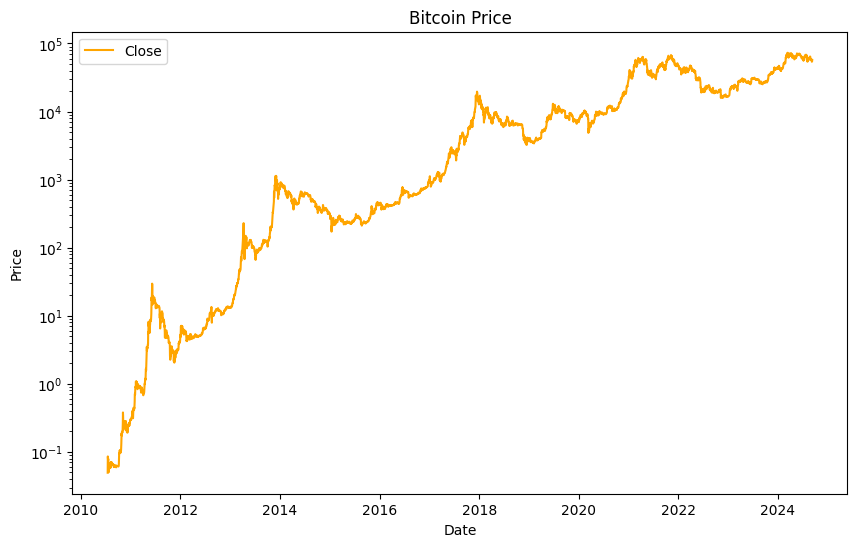

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Price'], label='Close', color='orange')
plt.yscale('log')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price')
plt.legend()
plt.show()

### Model 1 (Power Law)

$$ \bm{y} = \bm{X}\bm{\beta} + \bm{\epsilon} $$

Where:
- $\bm{y}$ is the log of the price
- $\bm{X}$ is the log of the days since the genesis block
- $\bm{\beta}$ is the vector of coefficients
- $\bm{\epsilon}$ is the error term

$$
\left[\begin{array}{ccc}
log(price_1)\\
log(price_2)\\
\vdots\\
log(price_n)
\end{array}\right]
=
\left[\begin{array}{ccc}
1 & log(days_1)\\
1 & log(days_2)\\
\vdots & \vdots\\
1 & log(days_n)
\end{array}\right]
\left[\begin{array}{ccc}
\beta_0\\
\beta_1
\end{array}\right]
+
\left[\begin{array}{ccc}
\epsilon_1\\
\epsilon_2\\
\vdots\\
\epsilon_n
\end{array}\right]
$$


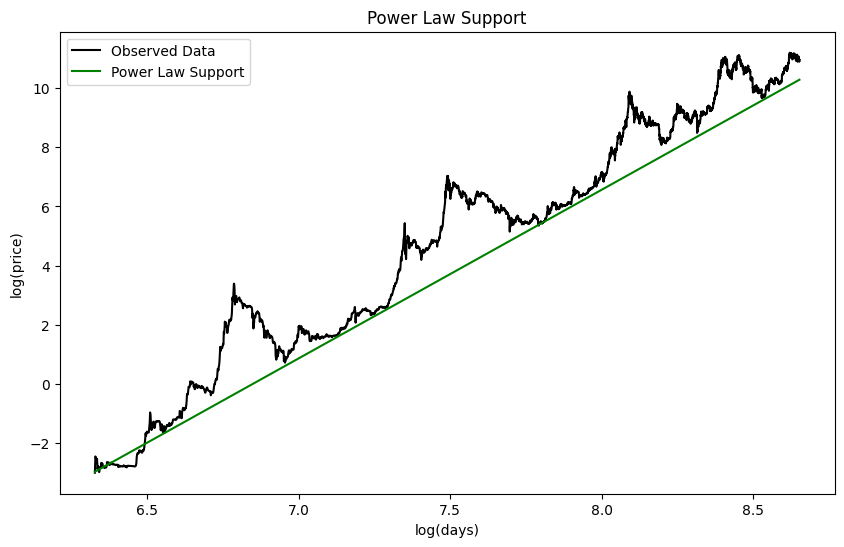

In [5]:
X = np.log(df['Days']).values.reshape(-1, 1)
y = np.log(df['Price']).values

X_with_const = add_constant(X)

model_power_law = OLS(y, X_with_const)
results_power_law = model_power_law.fit()

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Observed Data', color='black')
plt.plot(X, results_power_law.predict(X_with_const) - 0.95, label='Power Law Support', color='green')

plt.xlabel('log(days)')
plt.ylabel('log(price)')
plt.title('Power Law Support')
plt.legend()
plt.show()

### Model 2 (Quadratic Quantile Regression)

$$ \bm{y} = \bm{X}\bm{\beta} + \bm{\epsilon} $$

Where:
- $\bm{y}$ is the log of the price
- $\bm{X}$ is the log of the days since the genesis block with its square
- $\bm{\beta}$ is the vector of coefficients
- $\bm{\epsilon}$ is the error term

$$
\left[\begin{array}{ccc}
log(price_1)\\
log(price_2)\\
\vdots\\
log(price_n)
\end{array}\right]
=
\left[\begin{array}{ccc}
1 & log(days_1) & (log(days_1))^2\\
1 & log(days_2) & (log(days_2))^2\\
\vdots & \vdots & \vdots\\
1 & log(days_n) & (log(days_n))^2
\end{array}\right]
\left[\begin{array}{ccc}
\beta_0\\
\beta_1\\
\beta_2
\end{array}\right]
+
\left[\begin{array}{ccc}
\epsilon_1\\
\epsilon_2\\
\vdots\\
\epsilon_n
\end{array}\right]
$$


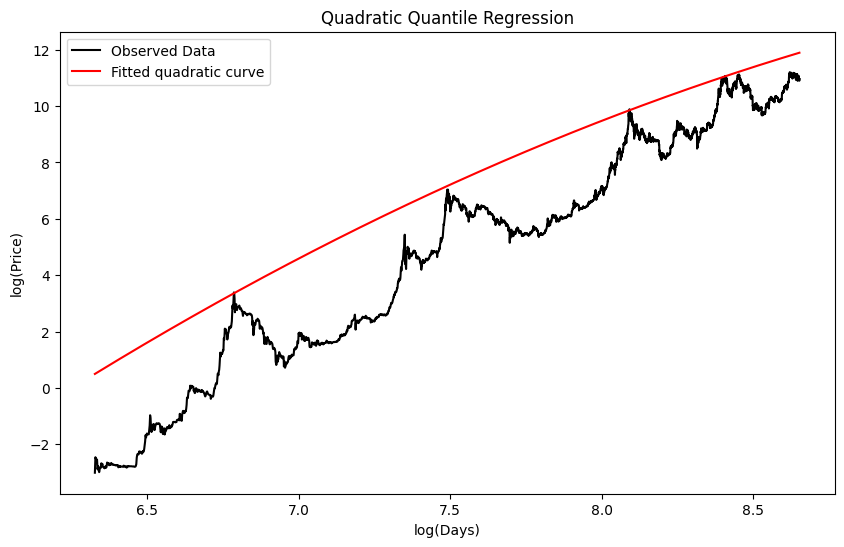

In [6]:
X_log_squared = np.vander(X.ravel(), 3)

X_log_squared_with_const = add_constant(X_log_squared)

model_quadratic = QuantReg(y, X_log_squared_with_const)
results_quadratic = model_quadratic.fit(q=0.999)

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Observed Data', color='black')
plt.plot(X, results_quadratic.predict(X_log_squared_with_const), label='Fitted quadratic curve', color='red')
plt.xlabel('log(Days)')
plt.ylabel('log(Price)')
plt.title('Quadratic Quantile Regression')
plt.legend()
plt.show()

### Calculate the oscillator

$$ y_{oscillator} \% = \frac{y - y_{lower}}{y_{upper} - y_{lower}} \times 100 $$

Where:
- $y_{lower}$ is the predicted value from the power law model shifted down
- $y_{upper}$ is the predicted value from the quadratic model


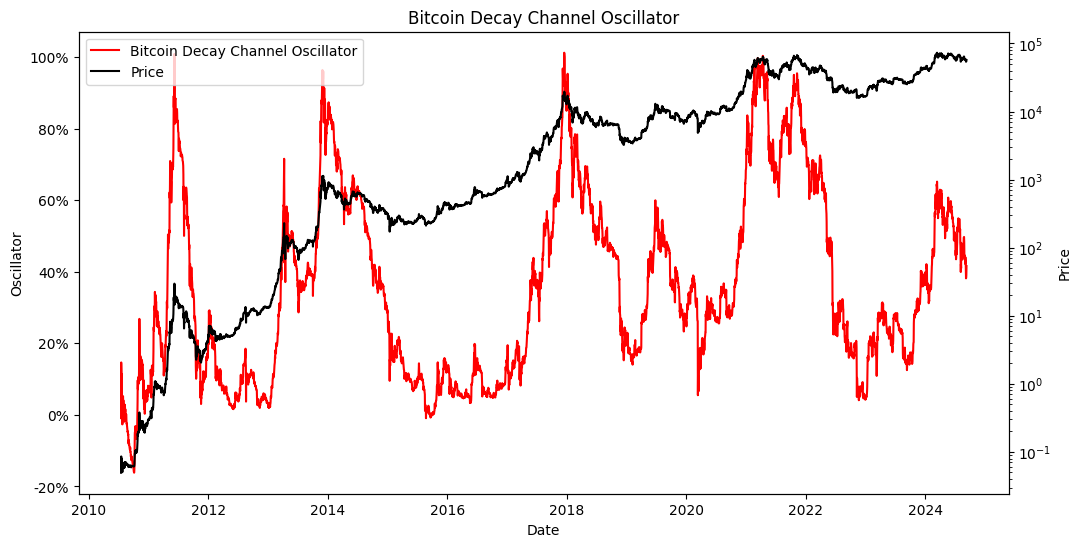

In [7]:
y_pred_power_law = results_power_law.predict(X_with_const) - 0.95
y_pred_quadratic = results_quadratic.predict(X_log_squared_with_const)

df['Oscillator'] = (y - y_pred_power_law) / (y_pred_quadratic - y_pred_power_law)

fig, ax = plt.subplots(figsize=(12, 6))
line1 = ax.plot(df['Date'], df['Oscillator'] * 100, color='red', label='Bitcoin Decay Channel Oscillator') # add np.log() to the oscillator
ax.set_ylabel('Oscillator')
ax.set_xlabel('Date')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

ax2 = ax.twinx()
line2 = ax2.plot(df['Date'], df['Price'], color='black', label='Price')
ax2.set_yscale("log")
ax2.set_ylabel('Price')

plt.title('Bitcoin Decay Channel Oscillator')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

plt.show()
